In [1]:
from keras.applications import inception_v3
from keras import backend as k

Using TensorFlow backend.


In [2]:
k.set_learning_phase(0)

model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)

In [3]:
layer_contributions = {
    
    'mixed2' : 0.7,
    'mixed3' : 2.2,
    'mixed4' : 1.2,
    'mixed5' : 0.8,
    
}

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = k.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    activation = layer_dict[layer_name].output
    scaling = k.prod(k.cast(k.shape(activation), 'float32'))
    
    loss = loss + coeff * k.sum(k.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [5]:
dream = model.input

grads = k.gradients(loss, dream)[0]

grads = grads / k.maximum(k.mean(k.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = k.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss = None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [6]:
import numpy as np
import scipy
from keras.preprocessing import image
import imageio

In [7]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order = 1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if k.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    
    

In [8]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.0

base_image_path = 'Kalsubai.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations = iterations,
                          step = step,
                          max_loss = max_loss)
    
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname = './deepdream_outputs/dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname = './deepdream_outputs/final_dream.png')
print('DeepDreaming Complete')

Processing image shape (413, 551)
...Loss value at 0 : 1.2843548
...Loss value at 1 : 1.5162852
...Loss value at 2 : 1.9484925
...Loss value at 3 : 2.4531052
...Loss value at 4 : 3.0114622
...Loss value at 5 : 3.561841
...Loss value at 6 : 4.132
...Loss value at 7 : 4.675925
...Loss value at 8 : 5.206576
...Loss value at 9 : 5.702019
...Loss value at 10 : 6.213132
...Loss value at 11 : 6.6707883
...Loss value at 12 : 7.1366196
...Loss value at 13 : 7.622164
...Loss value at 14 : 8.04161
...Loss value at 15 : 8.464124
...Loss value at 16 : 8.865223
...Loss value at 17 : 9.267358
...Loss value at 18 : 9.634758
...Loss value at 19 : 9.999737
Processing image shape (578, 771)
...Loss value at 0 : 2.9981217
...Loss value at 1 : 4.2912674
...Loss value at 2 : 5.2674212
...Loss value at 3 : 6.085045
...Loss value at 4 : 6.840214
...Loss value at 5 : 7.5095043
...Loss value at 6 : 8.14917
...Loss value at 7 : 8.729252
...Loss value at 8 : 9.277001
...Loss value at 9 : 9.784702
Processing image

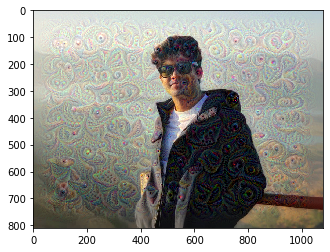

In [9]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

image_path = './deepdream_outputs/final_dream.png'

img1 = image.load_img(image_path)
plt.grid(False)
plt.imshow(img1)